INTRODUCCION:
En este notebook modelamos un sistema de colas en un hospital utilizando simulaciones. La simulación tiene como objetivo analizar el flujo de pacientes a través de diferentes unidades del hospital y la disponibilidad de camas en cada una de ellas. Utilizamos la biblioteca simpy para gestionar la simulación de eventos discretos y pandas para almacenar y analizar los datos obtenidos.

OBJETIVO:
El objetivo de esta simulación es modelar el flujo de pacientes en un hospital con distintas unidades de tratamiento, cada una con una capacidad limitada. Queremos analizar cómo se manejan los pacientes a través de estas unidades y evaluar el impacto de las capacidades de las unidades en los tiempos de espera y tratamiento.

DESCRIPCION:
En un hospital, los pacientes llegan para recibir diferentes tipos de tratamiento, que requieren distintos tipos de recursos limitados (camas). Cada unidad del hospital (Cuidados Intensivos, Urgencias, Consultas Externas) tiene una capacidad máxima, lo que significa que solo un número limitado de pacientes puede ser atendido en un momento dado. Los pacientes deben esperar si no hay recursos disponibles, lo que puede causar tiempos de espera adicionales.

DESCRIPCION DE PROBLEMAS DE COLAS: Cada unidad tiene una capacidad limitada de camas, y los pacientes deben esperar su turno si no hay camas disponibles. La simulación ayuda a entender cómo los tiempos de espera y la disponibilidad de camas afectan el flujo de pacientes.

DESAROLLO DE SIMULACION

In [29]:
import simpy
import pandas as pd
import numpy as np
import random

Cracion de Clase Paciente:

Se crea la clase de paciente que incluye el env que hace referencia al entorno donde ocurren todos los enventos, sel action que inicia el proceso de simulacion del paciente y hospital que referencia al hospital que llega el paciente. 

Definicion de proceso y Uso de container con sus recursos (Camas):

se define el proceso del paciente donde se registra el tiempo de llagada de un paciente y usamos container para los recursos limitados que en este caso son las camas disponibles en la unidad de tratamiento, el paciente tomara uno de estos recursos es decir la cama. se selecciona aleatoriamente un tipo de tratamiento y con timeout se simula el tiempo que el paciente pasara en la cama y se registra el tiempo con que el paciente es dado de alta con env.now y con append se almacenan los datos del paciente.

In [33]:
class Paciente:
    def __init__(self, env, hospital, paciente_id):
        self.env = env
        self.hospital = hospital
        self.paciente_id = paciente_id
        self.action = env.process(self.proceso())

    def proceso(self):
        # Tiempo de llegada del paciente
        llegada = int(self.env.now)
        print(f'Paciente {self.paciente_id} llega al hospital en el tiempo {llegada}.')
        
        # Selección aleatoria de tipo de tratamiento
        tipo_tratamiento = random.choice(list(self.hospital.unidades.keys()))

        # Contar pacientes en la unidad seleccionada
        self.hospital.pacientes_en_unidad[tipo_tratamiento] += 1
        
        # Intentar obtener una cama en la unidad seleccionada
        with self.hospital.unidades[tipo_tratamiento].get(1) as cama:
            yield cama
            print(f'Paciente {self.paciente_id} comienza tratamiento en {tipo_tratamiento} en el tiempo {int(self.env.now)}.')
            
            # Tiempo de tratamiento como entero
            tiempo_tratamiento = random.randint(5, 30)
            yield self.env.timeout(tiempo_tratamiento)
            
            # Tiempo de alta del paciente
            alta = int(self.env.now)
            print(f'Paciente {self.paciente_id} dado de alta de {tipo_tratamiento} en el tiempo {alta}.')
            
            # Registro del tratamiento
            self.hospital.registro.append({
                'Paciente_ID': self.paciente_id,
                'Tiempo_Llegada': llegada,
                'Tipo_Tratamiento': tipo_tratamiento,
                'Tiempo_Alta': alta
            })

Definicion de la clase hospital y uso de container:

Cada unidad de tratamiento es un Container con una capacidad inicial y una capacidad máxima que representa el número de camas disponibles, tambien tiene registro de pacientes.

Definicion de llegada de paciente:

simula la llegada de pacientes continua al hospital y con un intervalo se define el tiempo promedio de la llegada entre un paciente y otro, ademas genera un tiempo entre llegadas basado en una distribución exponencial, convertido a un entero y se crea un nuevo paciente que inicia su proceso en el hospital.

In [37]:
# Clase que representa al hospital
class Hospital:
    def __init__(self, env):
        self.env = env
        self.unidades = {
            'Cuidados Intensivos': simpy.Container(env, init=2, capacity=2),
            'Urgencias': simpy.Container(env, init=3, capacity=3),
            'Consultas Externas': simpy.Container(env, init=5, capacity=5)
        }
        self.registro = []
        self.pacientes_en_unidad = {key: 0 for key in self.unidades.keys()}

    def llegada_pacientes(self, intervalo):
        paciente_id = 1
        while True:
            # Intervalo de tiempo entre llegadas convertido a entero
            yield self.env.timeout(int(random.expovariate(1.0 / intervalo)))
            Paciente(self.env, self, paciente_id)
            paciente_id += 1

Configuracion de la simulacion:

se crea el entorno de la simulacion con env y se genera una instancia del hospital en ese entorno. Se inicia el proceso de llegada de pacientes al hospital con un intervalo promedio de 10 unidades de tiempo y Ejecuta la simulación durante 500 unidades de tiempo.

In [40]:
env = simpy.Environment()
hospital = Hospital(env)
env.process(hospital.llegada_pacientes(intervalo=10))
env.run(until=200)


Paciente 1 llega al hospital en el tiempo 28.
Paciente 1 comienza tratamiento en Urgencias en el tiempo 28.
Paciente 2 llega al hospital en el tiempo 40.
Paciente 2 comienza tratamiento en Urgencias en el tiempo 40.
Paciente 1 dado de alta de Urgencias en el tiempo 43.
Paciente 2 dado de alta de Urgencias en el tiempo 47.
Paciente 3 llega al hospital en el tiempo 98.
Paciente 3 comienza tratamiento en Consultas Externas en el tiempo 98.
Paciente 4 llega al hospital en el tiempo 111.
Paciente 4 comienza tratamiento en Urgencias en el tiempo 111.
Paciente 5 llega al hospital en el tiempo 114.
Paciente 3 dado de alta de Consultas Externas en el tiempo 115.
Paciente 6 llega al hospital en el tiempo 133.
Paciente 7 llega al hospital en el tiempo 133.
Paciente 6 comienza tratamiento en Cuidados Intensivos en el tiempo 133.
Paciente 8 llega al hospital en el tiempo 133.
Paciente 8 comienza tratamiento en Consultas Externas en el tiempo 133.
Paciente 4 dado de alta de Urgencias en el tiempo 14

Almacenamiento de Datos: 

Se convierte el registro de pacientes en un dataframe y se muestra el dataframe con los datos recolectados durante la simulacion.

In [43]:
df = pd.DataFrame(hospital.registro)
print(df)


   Paciente_ID  Tiempo_Llegada     Tipo_Tratamiento  Tiempo_Alta
0            1              28            Urgencias           43
1            2              40            Urgencias           47
2            3              98   Consultas Externas          115
3            4             111            Urgencias          141
4            8             133   Consultas Externas          143
5            6             133  Cuidados Intensivos          157
6            9             144   Consultas Externas          157
7           10             149   Consultas Externas          169
8           11             156   Consultas Externas          183


Análisis de la Simulación

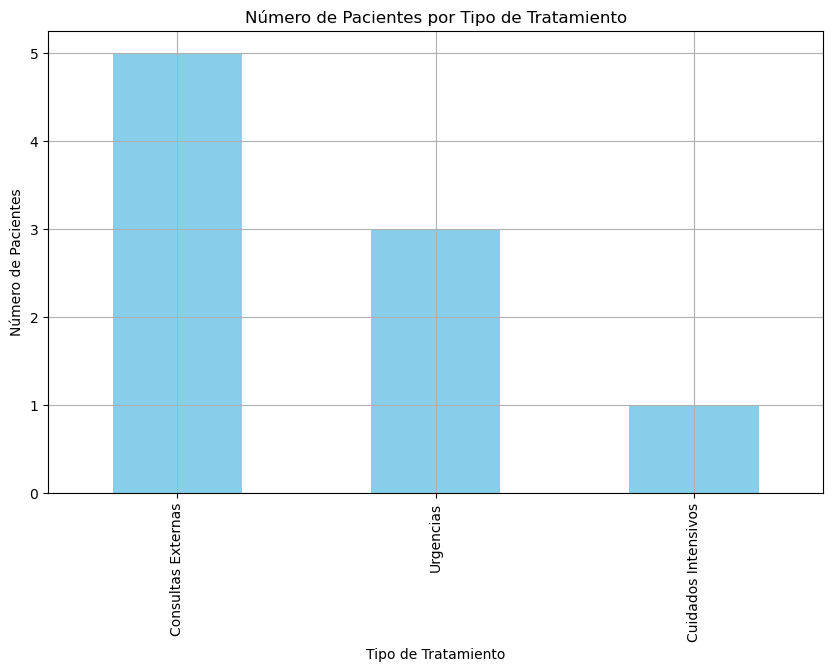

                     count       mean        std   min   25%   50%   75%   max
Tipo_Tratamiento                                                              
Consultas Externas     5.0  17.400000   6.580274  10.0  13.0  17.0  20.0  27.0
Cuidados Intensivos    1.0  24.000000        NaN  24.0  24.0  24.0  24.0  24.0
Urgencias              3.0  17.333333  11.676187   7.0  11.0  15.0  22.5  30.0


In [46]:
import matplotlib.pyplot as plt

# Conteo de pacientes por tipo de tratamiento
pacientes_por_tipo = df['Tipo_Tratamiento'].value_counts()

# Graficar la cantidad de pacientes por tipo de tratamiento
plt.figure(figsize=(10, 6))
pacientes_por_tipo.plot(kind='bar', color='skyblue')
plt.title('Número de Pacientes por Tipo de Tratamiento')
plt.xlabel('Tipo de Tratamiento')
plt.ylabel('Número de Pacientes')
plt.grid(True)
plt.show()

df['Tiempo_Espera'] = df['Tiempo_Alta'] - df['Tiempo_Llegada']

stats = df.groupby('Tipo_Tratamiento')['Tiempo_Espera'].describe()
print(stats)




Preguntas Hechas por el estudiante:

1. ¿Como se distribuyen los tiempos de espera entre los diferentes tipos de tratamiento?
2. ¿Cual es la unidad más utilizada y cuál es la menos utilizada (mayor uso de recursos)?
3. ¿Como afecta el tipo de tratamiento a los tiempos de espera y a la utilización de los recursos?

Respuestas segun el Analisis.

CONCLUSIONES

Independientemente de la aleatoriedad de los datos vemos que los tiempos de espera por cada unidad son altamente variables lo que indica los procedimientos o complejidad de cada proceso segun sea su unidad o la carga de trabajo de esta.
Tambien se entiende que las unidades con alta demanda y alta utilización de recursos podrían estar operando a su capacidad máxima, mientras que otras podrían estar infrautilizadas, por lo que se debe hacer una buena planificacion para obtener un equilibrio entre las unidades de tratamiento.
Como vemos esta simulacion toma datos aleatorios lo que lo vuelve un sistema flexible por lo que dentro de una planeacion se debe tomar en cuenta la variabilidad y estar preparadas para ajustar la capacidad y los recursos según las necesidades cambiantes.